In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Binding and Mutation Data Parsing

In [12]:
variant_mapping = {
    "Wuhan": "Wuhan-A",
    "A": "Alpha-B.1.1.7",
    "B": "Beta-B.1.351",
    "D": "Delta-B.1.617.2",
    "G": "Gamma-P.1",
    "O1": "Omicron-BA.1",
    "O2": "Omicron-BA.1.1",
    "O3": "Omicron-BA.2.12.1",
    "O4": "Omicron-BA.5.2.1",
}

binding_scores = pd.read_csv("mutation/binding-affinity.csv")
binding_scores["variant"] = binding_scores["Protein -protein complex"].str.split("-").str[0].map(variant_mapping)
binding_scores = binding_scores[["variant", "Binding affinity"]].groupby("variant").min().reset_index().set_index("variant")
binding_scores = binding_scores["Binding affinity"]

data = pd.read_csv("mutation/mutation-all.csv")
for var in data['variant'].unique():
    data["Against " + var] = data["variant"].map(binding_scores).apply(
        lambda x: 0 if x == binding_scores[var] else (1 if x > binding_scores[var] else -1)
    )
data.head()

,sequence,variant,D614G,N856S,G1124V,T19R,T95I,G142D,E156G,F157-,...,N969K,L981F,A243S,A829T,Against Beta-B.1.351,Against Delta-B.1.617.2,Against Gamma-P.1,Against Omicron-BA.1.1,Against Omicron-BA.1,Against Wuhan-A
0,Beta-B.1.351-S1,Beta-B.1.351,1,1,0,0,0,0,0,0,...,0,0,0,0,0,-1,-1,1,-1,-1
1,Beta-B.1.351-S2,Beta-B.1.351,1,1,1,0,0,0,0,0,...,0,0,0,0,0,-1,-1,1,-1,-1
2,Beta-B.1.351-S3,Beta-B.1.351,1,1,0,0,0,0,0,0,...,0,0,0,0,0,-1,-1,1,-1,-1
3,Beta-B.1.351-S4,Beta-B.1.351,1,1,1,0,0,0,0,0,...,0,0,0,0,0,-1,-1,1,-1,-1
4,Beta-B.1.351-S5,Beta-B.1.351,1,1,0,0,0,0,0,0,...,0,0,0,0,0,-1,-1,1,-1,-1


# Structure Difference Data Parsing + Feature Extraction

In [40]:
def sliding_window_features(signal, window_size=10, step=5):
    """Apply sliding window transformation to extract statistical features"""
    features = []
    for start in range(0, len(signal) - window_size + 1, step):
        window = signal[start:start + window_size]
        stats = [start, np.mean(window), np.std(window), np.min(window), np.max(window)]
        features.append(stats)
    return np.array(features)

ca_distances = pd.read_csv("tmalign/residues_full.csv")
df = data.merge(ca_distances, on="sequence", how="left")
df = df.dropna()

# Apply sliding window transformation to ca_distances
print("Applying sliding window features to ca_distances...")
print(f"Original ca_distances shape: {ca_distances.shape}")

# Extract residue columns
residue_cols = [col for col in ca_distances.columns if col.startswith('residue_')]
print(f"Found {len(residue_cols)} residue columns: {residue_cols[:3]}...{residue_cols[-3:]}")

# Apply sliding window transformation to each sequence
sliding_window_data = []
for idx, row in df.iterrows():
    sequence_id = row['sequence']
    # Get the residue distance values for this sequence
    residue_distances = row[residue_cols].values.astype(float)
    
    # Apply sliding window transformation
    window_features = sliding_window_features(residue_distances, window_size=10, step=5)
    
    # Create a dictionary with the sequence ID and the sliding window features
    feature_dict = {'sequence': sequence_id}
    for i, feature_val in enumerate(window_features):
        feature_dict[f'sw_feature_{319 + int(feature_val[0])}_mean'] = feature_val[1]
        feature_dict[f'sw_feature_{319 + int(feature_val[0])}_std'] = feature_val[2]
        feature_dict[f'sw_feature_{319 + int(feature_val[0])}_min'] = feature_val[3]
        feature_dict[f'sw_feature_{319 + int(feature_val[0])}_max'] = feature_val[4]
    
    sliding_window_data.append(feature_dict)

# Convert to DataFrame
sliding_window_df = pd.DataFrame(sliding_window_data)
print(f"Sliding window features shape: {sliding_window_df.shape}")
print(f"Example sliding window features: {list(sliding_window_df.columns[1:4])}...{list(sliding_window_df.columns[-3:])}")

# Remove original residue columns and merge with sliding window features
df_without_residues = df.drop(columns=residue_cols)
df = df_without_residues.merge(sliding_window_df, on='sequence', how='left')

print(f"Final dataset shape after sliding window transformation: {df.shape}")
print(f"Feature columns (excluding metadata): {len([col for col in df.columns if col not in ['sequence', 'variant'] + ['Against ' + var for var in df['variant'].unique()]])}")

Applying sliding window features to ca_distances...
Original ca_distances shape: (55, 223)
Found 222 residue columns: ['residue_319', 'residue_320', 'residue_321']...['residue_538', 'residue_539', 'residue_540']
Sliding window features shape: (48, 173)
Example sliding window features: ['sw_feature_319_mean', 'sw_feature_319_std', 'sw_feature_319_min']...['sw_feature_529_std', 'sw_feature_529_min', 'sw_feature_529_max']
Final dataset shape after sliding window transformation: (48, 248)
Feature columns (excluding metadata): 240


In [41]:
df

,sequence,variant,D614G,N856S,G1124V,T19R,T95I,G142D,E156G,F157-,...,sw_feature_519_min,sw_feature_519_max,sw_feature_524_mean,sw_feature_524_std,sw_feature_524_min,sw_feature_524_max,sw_feature_529_mean,sw_feature_529_std,sw_feature_529_min,sw_feature_529_max
0,Beta-B.1.351-S1,Beta-B.1.351,1,1,0,0,0,0,0,0,...,3.081011,4.068358,3.901690,4.931348e-01,2.728680,4.414555,3.557145,6.607782e-01,2.728680,4.414555
1,Beta-B.1.351-S2,Beta-B.1.351,1,1,1,0,0,0,0,0,...,1.078315,3.380650,1.078315,2.220446e-16,1.078315,1.078315,1.078315,2.220446e-16,1.078315,1.078315
2,Beta-B.1.351-S3,Beta-B.1.351,1,1,0,0,0,0,0,0,...,3.003322,4.318505,4.137371,4.634357e-01,3.275268,4.694272,3.866977,5.996861e-01,3.275268,4.694272
3,Beta-B.1.351-S4,Beta-B.1.351,1,1,1,0,0,0,0,0,...,1.078315,3.380650,1.078315,2.220446e-16,1.078315,1.078315,1.078315,2.220446e-16,1.078315,1.078315
4,Beta-B.1.351-S5,Beta-B.1.351,1,1,0,0,0,0,0,0,...,1.078315,3.380650,1.078315,2.220446e-16,1.078315,1.078315,1.078315,2.220446e-16,1.078315,1.078315
5,Beta-B.1.351-S6,Beta-B.1.351,1,1,0,0,0,0,0,0,...,1.054967,3.372913,1.054967,2.220446e-16,1.054967,1.054967,1.054967,2.220446e-16,1.054967,1.054967
6,Beta-B.1.351-S7,Beta-B.1.351,1,1,0,0,0,0,0,0,...,0.988879,3.467566,0.988879,0.000000e+00,0.988879,0.988879,0.988879,0.000000e+00,0.988879,0.988879
7,Beta-B.1.351-S8,Beta-B.1.351,1,1,0,0,0,0,0,0,...,2.994479,3.879247,3.751493,4.950998e-01,2.594895,4.389370,3.384773,6.820658e-01,2.594895,4.389370
8,Delta-B.1.617.2-S1,Delta-B.1.617.2,1,0,0,1,1,1,0,0,...,1.182474,4.018763,3.978245,8.774835e-01,2.398026,4.829132,4.788614,1.215553e-01,4.423948,4.829132
9,Delta-B.1.617.2-S2,Delta-B.1.617.2,1,0,0,1,0,0,1,1,...,1.415609,4.186750,2.264392,3.250590e-01,1.755122,2.773661,2.830247,3.250590e-01,2.320977,3.339516


In [42]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

def convert_to_classes(y):
    """Convert -1, 1 to class indices 0, 1"""
    return (y + 1) // 2  # -1->0, 1->1

def convert_from_classes(class_indices):
    """Convert class indices 0, 1 back to -1, 1"""
    return class_indices * 2 - 1  # 0->-1, 1->1

def train_single_model(X_train, y_train, X_test, y_test, epochs=100):
    # Filter out rows where y == 0
    train_mask = y_train != 0
    test_mask = y_test != 0
    
    X_train_filtered = X_train[train_mask]
    y_train_filtered = y_train[train_mask]
    X_test_filtered = X_test[test_mask]
    y_test_filtered = y_test[test_mask]
    
    # Convert targets to class indices for SVM
    y_train_classes = convert_to_classes(y_train_filtered)
    y_test_classes = convert_to_classes(y_test_filtered)
    
    # Scale the features for SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_filtered)
    X_test_scaled = scaler.transform(X_test_filtered)
    
    # Create and train SVM classifier
    # Using RBF kernel with default parameters
    model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    model.fit(X_train_scaled, y_train_classes)
    
    # Make predictions
    train_pred_classes = model.predict(X_train_scaled)
    test_pred_classes = model.predict(X_test_scaled)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(y_train_classes, train_pred_classes)
    test_accuracy = accuracy_score(y_test_classes, test_pred_classes)
    
    # Convert back to original labels (-1, 1)
    train_pred_original = convert_from_classes(train_pred_classes)
    test_pred_original = convert_from_classes(test_pred_classes)
    
    print(y_test_filtered, test_pred_original)
    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'test_predictions': test_pred_original,
        'test_actual': y_test_filtered,
        'n_train_samples': len(y_train_filtered),
        'n_test_samples': len(y_test_filtered)
    }

In [43]:
ORDER = ["Wuhan-A", "Beta-B.1.351", "Alpha-B.1.1.7", "Gamma-P.1", "Omicron-BA.1", "Delta-B.1.617.2", "Omicron-BA.2.12.1", "Omicron-BA.5.2.1", "Omicron-BA.1.1"]

In [44]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

def comprehensive_svm_validation(X_train, y_train, X_test, y_test, svm_params=None):
    """
    Comprehensive SVM validation with multiple metrics and cross-validation
    """
    if svm_params is None:
        svm_params = {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
    
    # Filter out rows where y == 0
    train_mask = y_train != 0
    test_mask = y_test != 0
    
    X_train_filtered = X_train[train_mask]
    y_train_filtered = y_train[train_mask]
    X_test_filtered = X_test[test_mask]
    y_test_filtered = y_test[test_mask]
    
    if len(X_train_filtered) == 0 or len(X_test_filtered) == 0:
        return None
    
    # Convert targets to class indices for SVM
    y_train_classes = convert_to_classes(y_train_filtered)
    y_test_classes = convert_to_classes(y_test_filtered)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_filtered)
    X_test_scaled = scaler.transform(X_test_filtered)
    
    # Create and train SVM
    model = SVC(random_state=42, **svm_params)
    model.fit(X_train_scaled, y_train_classes)
    
    # Predictions
    train_pred_classes = model.predict(X_train_scaled)
    test_pred_classes = model.predict(X_test_scaled)
    
    # Calculate comprehensive metrics
    train_accuracy = accuracy_score(y_train_classes, train_pred_classes)
    test_accuracy = accuracy_score(y_test_classes, test_pred_classes)
    
    # Only calculate precision/recall/f1 if both classes are present
    test_precision = test_recall = test_f1 = 0.0
    if len(np.unique(y_test_classes)) > 1 and len(np.unique(test_pred_classes)) > 1:
        test_precision = precision_score(y_test_classes, test_pred_classes, average='weighted', zero_division=0)
        test_recall = recall_score(y_test_classes, test_pred_classes, average='weighted', zero_division=0)
        test_f1 = f1_score(y_test_classes, test_pred_classes, average='weighted', zero_division=0)
    
    # Cross-validation on training data (if enough samples)
    cv_scores = []
    if len(X_train_filtered) >= 6:  # Need at least 6 samples for 3-fold CV
        try:
            cv = StratifiedKFold(n_splits=min(3, len(X_train_filtered)//2), shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train_scaled, y_train_classes, cv=cv, scoring='accuracy')
        except:
            cv_scores = []
    
    # Convert back to original labels
    test_pred_original = convert_from_classes(test_pred_classes)
    
    # Mean absolute difference
    mean_diff = np.mean(np.abs(test_pred_original - y_test_filtered))
    
    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'cv_mean': np.mean(cv_scores) if len(cv_scores) > 0 else 0.0,
        'cv_std': np.std(cv_scores) if len(cv_scores) > 0 else 0.0,
        'mean_diff': mean_diff,
        'test_predictions': test_pred_original,
        'test_actual': y_test_filtered,
        'n_train_samples': len(y_train_filtered),
        'n_test_samples': len(y_test_filtered),
        'confusion_matrix': confusion_matrix(y_test_classes, test_pred_classes).tolist()
    }

# Dictionary to store comprehensive metrics for heatmap
heatmap_data = {}
detailed_results = {}

# Test different SVM configurations
svm_configs = [
    {'name': 'RBF_default', 'params': {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}},
    {'name': 'RBF_high_C', 'params': {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}},
    {'name': 'Linear', 'params': {'C': 1.0, 'kernel': 'linear'}},
]

print("Running comprehensive SVM validation with multiple configurations...")
print("=" * 70)

for validation in ORDER:
    VALIDATION_VARIANT = validation
    if VALIDATION_VARIANT not in df["variant"].unique():
        continue
    
    X = df.drop(columns=["sequence", "variant"] + ["Against " + var for var in df['variant'].unique()]).values.astype(float)
    y = df["Against " + VALIDATION_VARIANT].values.astype(float)
    for var in df["variant"].unique():
        if var == VALIDATION_VARIANT:
            continue
            
        mask = (df["variant"] == VALIDATION_VARIANT) | (df["variant"] == var)
        X_train = X[~mask]
        y_train = y[~mask]
        X_test = X[mask]
        y_test = y[mask]
            
        if len(set(y_train)) == 1:
            continue
        
        print(f"\\nProcessing {VALIDATION_VARIANT} vs {var}: {X_train.shape}, {y_train.shape}, {X_test.shape}, {y_test.shape}")
        
        best_config = None
        best_accuracy = -1
        
        # Test each SVM configuration
        for config in svm_configs:
            result = comprehensive_svm_validation(X_train, y_train, X_test, y_test, config['params'])
            
            if result is not None:
                print(f"  {config['name']}: Accuracy={result['test_accuracy']:.3f}, F1={result['test_f1']:.3f}, CV={result['cv_mean']:.3f}±{result['cv_std']:.3f}")
                
                # Track best configuration based on test accuracy
                if result['test_accuracy'] > best_accuracy:
                    best_accuracy = result['test_accuracy']
                    best_config = config['name']
                    heatmap_data[(VALIDATION_VARIANT, var)] = result['mean_diff']
                    detailed_results[(VALIDATION_VARIANT, var)] = result
        
        if best_config:
            print(f"  → Best config: {best_config} (Accuracy: {best_accuracy:.3f})")
        else:
            print(f"  → No valid predictions for {VALIDATION_VARIANT} vs {var}")

print("\\n" + "=" * 70)
print("Completed SVM validation with hyperparameter testing!")



Running comprehensive SVM validation with multiple configurations...
\nProcessing Wuhan-A vs Beta-B.1.351: (32, 240), (32,), (16, 240), (16,)
  RBF_default: Accuracy=1.000, F1=0.000, CV=0.970±0.043
  RBF_high_C: Accuracy=1.000, F1=0.000, CV=0.970±0.043
  Linear: Accuracy=1.000, F1=0.000, CV=1.000±0.000
  → Best config: RBF_default (Accuracy: 1.000)
\nProcessing Wuhan-A vs Delta-B.1.617.2: (32, 240), (32,), (16, 240), (16,)
  RBF_default: Accuracy=1.000, F1=0.000, CV=0.970±0.043
  RBF_high_C: Accuracy=1.000, F1=0.000, CV=0.970±0.043
  Linear: Accuracy=0.750, F1=0.000, CV=0.970±0.043
  → Best config: RBF_default (Accuracy: 1.000)
\nProcessing Wuhan-A vs Omicron-BA.1.1: (32, 240), (32,), (16, 240), (16,)
  RBF_default: Accuracy=1.000, F1=0.000, CV=0.970±0.043
  RBF_high_C: Accuracy=1.000, F1=0.000, CV=0.970±0.043
  Linear: Accuracy=1.000, F1=0.000, CV=0.909±0.129
  → Best config: RBF_default (Accuracy: 1.000)
\nProcessing Wuhan-A vs Omicron-BA.1: (32, 240), (32,), (16, 240), (16,)
  RBF_d

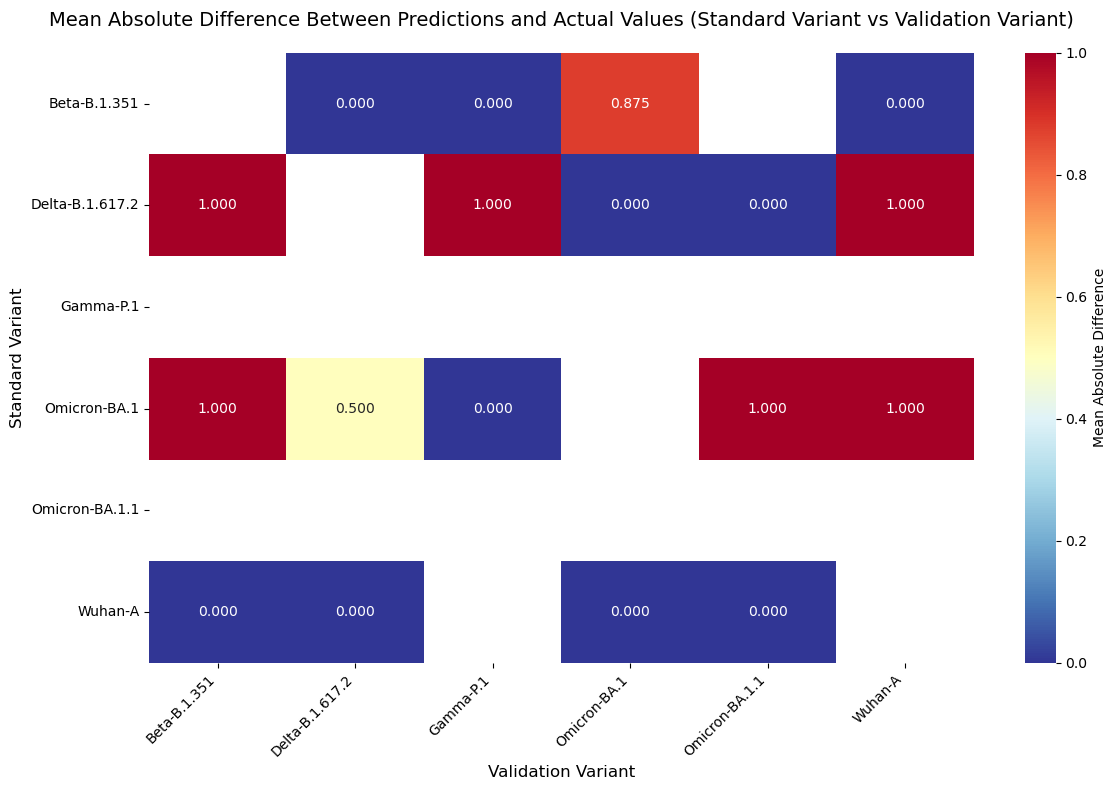

\nHEATMAP SUMMARY:
Beta-B.1.351 vs Delta-B.1.617.2: 0.0000
Beta-B.1.351 vs Gamma-P.1: 0.0000
Beta-B.1.351 vs Omicron-BA.1: 1.7500
Beta-B.1.351 vs Wuhan-A: 0.0000
Delta-B.1.617.2 vs Beta-B.1.351: 2.0000
Delta-B.1.617.2 vs Gamma-P.1: 2.0000
Delta-B.1.617.2 vs Omicron-BA.1: 0.0000
Delta-B.1.617.2 vs Omicron-BA.1.1: 0.0000
Delta-B.1.617.2 vs Wuhan-A: 2.0000
Omicron-BA.1 vs Beta-B.1.351: 2.0000
Omicron-BA.1 vs Delta-B.1.617.2: 1.0000
Omicron-BA.1 vs Gamma-P.1: 0.0000
Omicron-BA.1 vs Omicron-BA.1.1: 2.0000
Omicron-BA.1 vs Wuhan-A: 2.0000
Wuhan-A vs Beta-B.1.351: 0.0000
Wuhan-A vs Delta-B.1.617.2: 0.0000
Wuhan-A vs Omicron-BA.1: 0.0000
Wuhan-A vs Omicron-BA.1.1: 0.0000


In [45]:
# Create heatmap data structure
validation_variants = sorted([v for v in ORDER if v in df["variant"].unique()])
comparison_variants = sorted(df["variant"].unique())

# Create matrix for heatmap
heatmap_matrix = np.full((len(validation_variants), len(comparison_variants)), np.nan)
for i, val_var in enumerate(validation_variants):
    for j, comp_var in enumerate(comparison_variants):
        if (val_var, comp_var) in heatmap_data:
            heatmap_matrix[i, j] = heatmap_data[(val_var, comp_var)] / 2

# Create the heatmap
plt.figure(figsize=(12, 8))
import seaborn as sns

# Create heatmap with custom colormap
sns.heatmap(heatmap_matrix, 
            xticklabels=comparison_variants,
            yticklabels=validation_variants,
            annot=True, 
            fmt='.3f',
            cmap='RdYlBu_r',  # Red for high differences, blue for low
            cbar_kws={'label': 'Mean Absolute Difference'},
            mask=np.isnan(heatmap_matrix))

plt.title('Mean Absolute Difference Between Predictions and Actual Values (Standard Variant vs Validation Variant)', fontsize=14, pad=20)
plt.xlabel('Validation Variant', fontsize=12)
plt.ylabel('Standard Variant', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\\nHEATMAP SUMMARY:")
print("=" * 50)
for (val_var, comp_var), mean_diff in sorted(heatmap_data.items()):
    print(f"{val_var} vs {comp_var}: {mean_diff:.4f}")


In [46]:
# =============================================================================
# SVM TRAINING WITHOUT VALIDATION - ENTIRE DATASET
# =============================================================================

print("\n" + "=" * 70)
print("Training SVM models on entire dataset (no validation split)...")
print("=" * 70)

# Get unique variants from ORDER that exist in the dataset
ORDER = ["Wuhan-A", "Beta-B.1.351", "Alpha-B.1.1.7", "Gamma-P.1", "Omicron-BA.1", "Delta-B.1.617.2", "Omicron-BA.2.12.1", "Omicron-BA.5.2.1", "Omicron-BA.1.1"]
available_variants = [var for var in ORDER if var in df["variant"].unique()]
n_variants = len(available_variants)

# Create variant to index mapping for 6x6 matrix
variant_to_idx = {var: i for i, var in enumerate(available_variants)}
idx_to_variant = {i: var for i, var in enumerate(available_variants)}

# Initialize 6x6 model storage (using max 6 variants, can adjust if needed)
svm_models = [None] * 6
svm_scalers = [None] * 6
model_info = [None] * 6

def train_full_dataset_svm_debug(comparison_variant, svm_params=None):
    """
    Train SVM on entire dataset for given variant pair - WITH DEBUG INFO
    """
    if svm_params is None:
        svm_params = {'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}
    
    # Get features and target
    X = df.drop(columns=["sequence", "variant"] + ["Against " + var for var in df['variant'].unique()]).values.astype(float)
    y = df["Against " + comparison_variant].values.astype(float)
    
    # Filter for the specific variant pair
    mask = (df["variant"] == comparison_variant)
    X_filtered = X[~mask]
    y_filtered = y[~mask]
    
    print(f"  After variant filtering: X={X_filtered.shape}, y={y_filtered.shape}")
    print(f"  y values: {np.unique(y_filtered, return_counts=True)}")
    
    # Remove rows where y == 0 (neutral cases)
    data_mask = y_filtered != 0
    X_final = X_filtered[data_mask]
    y_final = y_filtered[data_mask]
    
    print(f"  After removing y==0: X={X_final.shape}, y={y_final.shape}")
    if len(y_final) > 0:
        print(f"  Final y values: {np.unique(y_final, return_counts=True)}")
        print(f"  Number of unique classes: {len(set(y_final))}")
    
    if len(X_final) == 0:
        print("  → ISSUE: No samples left after filtering")
        return None, None, None
    
    if len(set(y_final)) == 1:
        print("  → ISSUE: All samples have the same label")
        return None, None, None
    
    # Convert targets to class indices for SVM
    y_classes = convert_to_classes(y_final)
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_final)
    
    # Create and train SVM
    model = SVC(random_state=42, **svm_params)
    model.fit(X_scaled, y_classes)
    
    # Calculate training accuracy for info
    train_pred = model.predict(X_scaled)
    train_accuracy = accuracy_score(y_classes, train_pred)
    
    info = {
        'comparison_variant': comparison_variant,
        'n_samples': len(y_final),
        'train_accuracy': train_accuracy,
        'svm_params': svm_params,
        'feature_names': [f'feature_{i}' for i in range(X_scaled.shape[1])]
    }
    
    return model, scaler, info

# Train models for all variant pairs
trained_pairs = []


# Replace the training loop with debug version:
for i, comp_variant in enumerate(available_variants):
    print(f"Training SVM: {comp_variant}")
    
    model, scaler, info = train_full_dataset_svm_debug(comp_variant)
    
    if model is not None:
        svm_models[i] = model
        svm_scalers[i] = scaler 
        model_info[i] = info
        trained_pairs.append((comp_variant, i))
        print(f"  ✓ Trained successfully - Accuracy: {info['train_accuracy']:.3f}, Samples: {info['n_samples']}")
    else:
        print(f"  ✗ Failed to train")

print(f"\nCompleted training {len(trained_pairs)} SVM models!")
print("Available variants:", available_variants[:6])


Training SVM models on entire dataset (no validation split)...
Training SVM: Wuhan-A
  After variant filtering: X=(40, 240), y=(40,)
  y values: (array([-1.,  1.]), array([32,  8], dtype=int64))
  After removing y==0: X=(40, 240), y=(40,)
  Final y values: (array([-1.,  1.]), array([32,  8], dtype=int64))
  Number of unique classes: 2
  ✓ Trained successfully - Accuracy: 1.000, Samples: 40
Training SVM: Beta-B.1.351
  After variant filtering: X=(40, 240), y=(40,)
  y values: (array([-1.,  1.]), array([ 8, 32], dtype=int64))
  After removing y==0: X=(40, 240), y=(40,)
  Final y values: (array([-1.,  1.]), array([ 8, 32], dtype=int64))
  Number of unique classes: 2
  ✓ Trained successfully - Accuracy: 1.000, Samples: 40
Training SVM: Gamma-P.1
  After variant filtering: X=(40, 240), y=(40,)
  y values: (array([-1.]), array([40], dtype=int64))
  After removing y==0: X=(40, 240), y=(40,)
  Final y values: (array([-1.]), array([40], dtype=int64))
  Number of unique classes: 1
  → ISSUE: Al

In [47]:
# =============================================================================
# FEATURE INTERPRETATION - TOP FACTORS AFFECTING SEPARATION
# =============================================================================

print("=" * 70)
print("FEATURE INTERPRETATION ANALYSIS")
print("=" * 70)

def get_feature_importance_linear_svm(model, scaler, feature_names, top_n=10):
    """
    Extract feature importance from linear SVM coefficients
    """
    if model.kernel != 'linear':
        return None
    
    # Get the coefficients (weights) from the linear SVM
    coefficients = model.coef_[0]  # For binary classification, shape is (1, n_features)
    
    # Get feature importance as absolute values of coefficients
    feature_importance = np.abs(coefficients)
    
    # Get top features
    top_indices = np.argsort(feature_importance)[::-1][:top_n]
    
    results = []
    for idx in top_indices:
        results.append({
            'feature_index': idx,
            'feature_name': feature_names[idx] if idx < len(feature_names) else f'feature_{idx}',
            'coefficient': coefficients[idx],
            'abs_importance': feature_importance[idx]
        })
    
    return results

def interpret_svm_decision_boundary(model, scaler, X_sample, feature_names):
    """
    Analyze which features most influence the decision boundary
    """
    if model.kernel != 'linear':
        return "Feature interpretation only available for linear kernels"
    
    # Get the decision function scores for sample points
    X_scaled = scaler.transform(X_sample)
    decision_scores = model.decision_function(X_scaled)
    
    # Get coefficients
    coefficients = model.coef_[0]
    intercept = model.intercept_[0]
    
    return {
        'coefficients': coefficients,
        'intercept': intercept,
        'decision_scores': decision_scores
    }

# Get feature names from the dataframe
feature_columns = [col for col in df.columns if col not in ["sequence", "variant"] + ["Against " + var for var in df['variant'].unique()]]
print(f"Total features available: {len(feature_columns)}")
print(f"Feature columns: {feature_columns[:10]}...")  # Show first 10

print("\n" + "-" * 70)
print("FEATURE IMPORTANCE FOR EACH VARIANT PAIR")
print("-" * 70)

# Analyze feature importance for each trained model
for comp_variant, i in trained_pairs:
    model = svm_models[i]
    scaler = svm_scalers[i]
    info = model_info[i]

    print("=" * 50)
    
    if model.kernel == 'linear':
        # Get feature importance
        importance = get_feature_importance_linear_svm(model, scaler, feature_columns, top_n=15)
        
        if importance:
            print("Top 15 most important features:")
            print(f"{'Rank':<4} {'Feature':<25} {'Coefficient':<12} {'Importance':<12}")
            print("-" * 65)
            
            for rank, feat_info in enumerate(importance, 1):
                feat_name = feat_info['feature_name']
                if len(feat_name) > 22:
                    feat_name = feat_name[:22] + "..."
                    
                print(f"{rank:<4} {feat_name:<25} {feat_info['coefficient']:<12.4f} {feat_info['abs_importance']:<12.4f}")
            
            # Interpretation
            pos_features = [f for f in importance if f['coefficient'] > 0]
            neg_features = [f for f in importance if f['coefficient'] < 0]
            
            print(f"\nInterpretation:")
            if pos_features:
                top_pos = pos_features[0]['feature_name']
                print(f"  → Strongest positive influence: {top_pos}")
            
            print(f"• Features favoring {comp_variant} class (-1): {len(neg_features)} features") 
            if neg_features:
                top_neg = neg_features[0]['feature_name']
                print(f"  → Strongest negative influence: {top_neg}")
                
        else:
            print("Could not extract feature importance")
    else:
        print(f"Non-linear kernel ({model.kernel}) - feature importance not directly interpretable")
        print("Consider using SHAP values or permutation importance for non-linear models")

print(f"\n" + "=" * 70)
print("SUMMARY OF FEATURE INTERPRETATION")
print("=" * 70)

# Summary analysis across all models
all_feature_importance = {}
model_count = 0

for comp_variant, i in trained_pairs:
    model = svm_models[i]
    if model.kernel == 'linear':
        model_count += 1
        importance = get_feature_importance_linear_svm(model, svm_scalers[i], feature_columns, top_n=len(feature_columns))
        
        if importance:
            for feat_info in importance:
                feat_name = feat_info['feature_name']
                if feat_name not in all_feature_importance:
                    all_feature_importance[feat_name] = []
                all_feature_importance[feat_name].append(feat_info['abs_importance'])

# Calculate average importance across all models
avg_importance = {}
for feat_name, importance_list in all_feature_importance.items():
    avg_importance[feat_name] = np.mean(importance_list)

# Sort by average importance
sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)

print(f"Average feature importance across {model_count} linear SVM models:")
print(f"{'Rank':<4} {'Feature':<30} {'Avg Importance':<15} {'Frequency':<10}")
print("-" * 70)

for rank, (feat_name, avg_imp) in enumerate(sorted_features[:20], 1):
    frequency = len(all_feature_importance[feat_name])
    feat_display = feat_name if len(feat_name) <= 27 else feat_name[:27] + "..."
    print(f"{rank:<4} {feat_display:<30} {avg_imp:<15.4f} {frequency}/{model_count}")

print(f"\nMost consistently important features:")
for feat_name, avg_imp in sorted_features[:5]:
    frequency = len(all_feature_importance[feat_name])
    print(f"• {feat_name}: avg importance = {avg_imp:.4f} (appears in {frequency}/{model_count} models)")

FEATURE INTERPRETATION ANALYSIS
Total features available: 240
Feature columns: ['D614G', 'N856S', 'G1124V', 'T19R', 'T95I', 'G142D', 'E156G', 'F157-', 'R158-', 'R158G']...

----------------------------------------------------------------------
FEATURE IMPORTANCE FOR EACH VARIANT PAIR
----------------------------------------------------------------------
Top 15 most important features:
Rank Feature                   Coefficient  Importance  
-----------------------------------------------------------------
1    T20N                      0.0438       0.0438      
2    V1176F                    0.0438       0.0438      
3    T1027I                    0.0416       0.0416      
4    R190S                     0.0416       0.0416      
5    D138Y                     0.0416       0.0416      
6    P26S                      0.0416       0.0416      
7    L18F                      0.0416       0.0416      
8    K417T                     0.0398       0.0398      
9    H655Y                     0.

In [55]:
mutation = pd.read_csv("mutation/mutation-all.csv").drop(columns=["sequence"]).groupby("variant").mean().reset_index()

mutation.to_csv("mutation/mutation-variant-count.csv", index=False)

